# Toronto Fire Services Data Analysis

As anyone who lives in Toronto would tell you, there is always a constant myriad of sirens echoing throughout the 
city. Quantifying the instances of firetrucks speeding down the downtown core is made easy with publicly available data. An easily readable map of the city of Toronto with an overlay of fire incidence per given location would allow any regular citizen to corroborate their everyday findings with real data. 

This project aims to run a breakdown analysis on fire incident data that was collected by the City of Toronto Fire Services. The datasets consist of response time intervals (dispatch, enroute, arrive and clear) and responding units, in additional to the geographical coordinates of the incidents that took place between 2011 and 2017. For privacy purposes personal information is not provided on all incidents and for medical incidents some information has been altered. If data is related to medical incidents the Forward Sortation Area (FSA) is provided in place of the Major Street and Cross Street fields. 

More information can be found at https://open.toronto.ca/dataset/fire-services-basic-incident-details/


In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import urllib
import json

from datetime import datetime
from collections import Counter
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile


import matplotlib.pyplot as plt
%matplotlib inline

### Loading Data from City of Toronto website into

In [9]:
# https://open.toronto.ca/dataset/fire-services-basic-incident-details/
# df = pd.read_csv("/Users/chengh/Documents/projects/TFS/2011-2017_Basic_Incident_Details.csv")

In [3]:
def load_data(url, params):
    response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
    package = json.loads(response.read())
    
    for i in range(8):
        zipurl = package["result"].get('resources')[0].get('url')

        z = urlopen(zipurl)
        myzip = ZipFile(BytesIO(z.read())).extract(f'201{i+1}_Basic_Incident_Details.csv')
        df = pd.read_csv(myzip)
        
        print(f'201{i+1}_Basic_Incident_Details.csv')

In [4]:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "263f54b6-5c60-434f-8958-4e11248f08ff"}

load_data(url=url, params=params)

2011_Basic_Incident_Details.csv
2012_Basic_Incident_Details.csv
2013_Basic_Incident_Details.csv
2014_Basic_Incident_Details.csv
2015_Basic_Incident_Details.csv
2016_Basic_Incident_Details.csv
2017_Basic_Incident_Details.csv
2018_Basic_Incident_Details.csv


In [42]:
files = glob.glob('*.csv')
files = sorted(files)

df = [pd.read_csv(filename) for filename in files]

for dataframe, filename in zip(df, files):
    dataframe['filename'] = filename

In [ ]:
# url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
# params = { "id": "263f54b6-5c60-434f-8958-4e11248f08ff"}

# response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
# package = json.loads(response.read())
# package["result"]

# package["result"].get('resources')[0].get('url')

# df = pd.concat([pd.read_csv(f) for f in glob.glob('*.csv')])

# Data Preprocessing

# EDA 

CAD - computed aided dispatch event type

Group the event types less categories that are given currently:
- Initial CAD event type 
- Initial CAD Event Call Type
- Final Incident Type 
- Call Source 

Which incident Ward has the most calls 
- During what hours?
- During what seasons? 
- During what months? 
- During what days of the week


Distribution by (incident types / incident ward):
- Year 
- Month 
- Days of week 

In [13]:
dfs = [df1, df2, df3, df4, df5, df6, df7]

for i in dfs:
    print(i.shape)

(144813, 15)
(120589, 15)
(109427, 15)
(111716, 15)
(115686, 15)
(116805, 15)
(122423, 15)


In [14]:
df.head()

,Incident Number,Initial CAD Event Type,Initial CAD Event Call Type,Final Incident Type,Event Alarm Level,Call Source,Incident Station Area,Incident Ward,LATITUDE,Longitude,Intersection,TFS Alarm Time,TFS Arrival Time,Last TFS Unit Clear Time,Persons Rescued
0,F11000010,Medical,Medical,89 - Other Medical,1,03 - From Ambulance,342.0,9,43.679099,-79.461761,Silverthorn Ave / Turnberry Ave,2011-01-01 00:03:43,2011-01-01 00:10:02,2011-01-01 00:31:18,0.0
1,F11000011,Medical,Carbon Monoxide,89 - Other Medical,1,01 - 911,131.0,15,43.726342,-79.396401,Lawrence Ave E / Mount Pleasant Rd,2011-01-01 00:03:55,2011-01-01 00:09:02,2011-01-01 00:15:13,0.0
2,F11000012,Medical,Medical,89 - Other Medical,1,03 - From Ambulance,324.0,14,43.668548,-79.335324,Endean Ave / Jones Ave,2011-01-01 00:05:03,2011-01-01 00:09:34,2011-01-01 00:27:11,0.0
3,F11000013,FIG - Fire - Grass/Rubbish,Emergency Fire,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",1,01 - 911,345.0,9,43.657123,-79.434313,Dufferin St / Dufferin Park Ave,2011-01-01 00:04:46,2011-01-01 00:10:46,2011-01-01 00:20:39,0.0
4,F11000014,FAHR - Alarm Highrise Residential,Emergency Fire,"33 - Human - Malicious intent, prank",1,05 - Telephone from Monitoring Agency,142.0,7,43.759840,-79.516182,Driftwood Ave / Wilmont Dr,2011-01-01 00:06:07,2011-01-01 00:11:03,2011-01-01 00:21:11,0.0


In [15]:
df.describe()

,Event Alarm Level,Incident Station Area,Incident Ward,LATITUDE,Longitude,Persons Rescued
count,841459.000000,841400.000000,841459.000000,841411.000000,841411.000000,841397.000000
mean,0.126064,282.415130,11.957908,43.705638,-79.397805,0.027057
std,0.338902,108.088085,6.812799,0.052104,0.099932,0.422291
min,0.000000,111.000000,0.000000,43.587092,-79.636534,0.000000
25%,0.000000,214.000000,6.000000,43.661564,-79.466604,0.000000
50%,0.000000,313.000000,12.000000,43.698401,-79.396566,0.000000
75%,0.000000,344.000000,18.000000,43.749044,-79.333430,0.000000
max,6.000000,445.000000,25.000000,43.853169,-79.123103,154.000000



### City of Toronto division: 
- Old Toronto
- East York
- Etobicoke
- North York
- Scarborough
- York

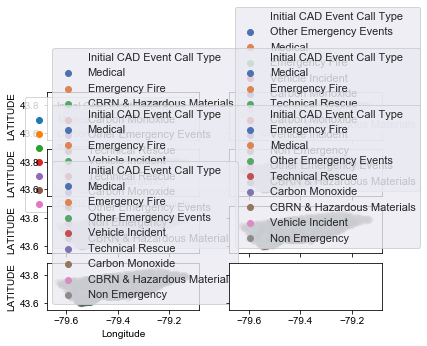

In [17]:
fig, axes= plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True)
sns.set_style('white')


for year, df in enumerate(dfs):
    
    ix = np.unravel_index(year, axes.shape)
#     groups.plot(ax=axes[ix], kind='scatter', x = 'Longitude', y = 'LATITUDE', 
#             figsize=(23,30), title=year+2011, alpha=0.003, )
    
    

    sns.scatterplot(x=df['Longitude'], 
                    y=df['LATITUDE'],
                    data=df, 
                    hue='Initial CAD Event Call Type', 
#                     palette='Set2',
                    alpha=0.003, ax=axes[ix], legend='brief')
    sns.set(rc={'figure.figsize':(23,30)})

    

In [7]:
dt1 = df1[(df1['LATITUDE'] <=43.7) & (df1['Longitude'] > -79.42) & (df1['Longitude'] < -79.33)]

In [17]:
df['weekday'] = df['TFS Alarm Time'].dt.dayofweek + 1

qual = ['Initial CAD Event Type', 'Initial CAD Event Call Type', 'Final Incident Type', 
       'Event Alarm Level', 'Call Source', 'weekday']

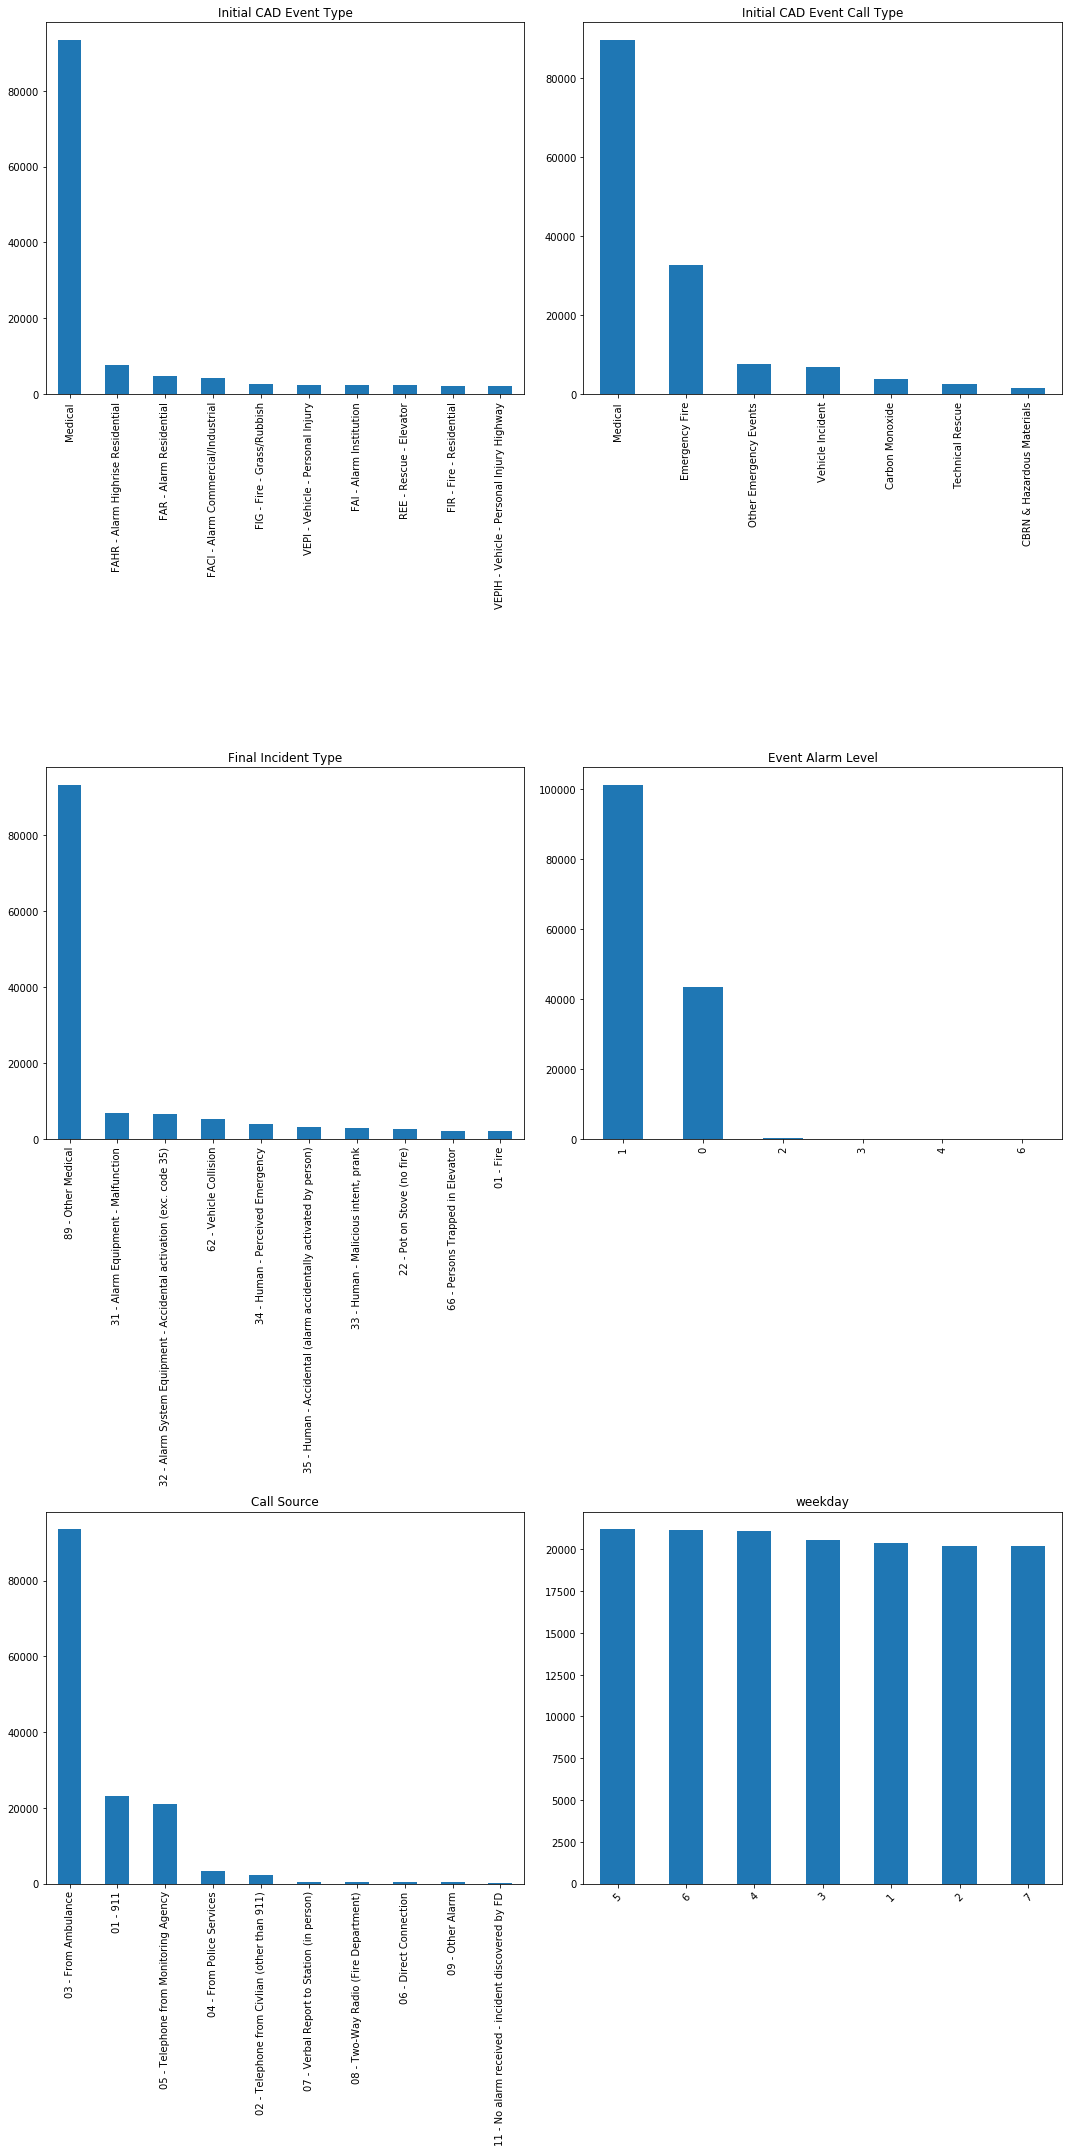

In [18]:
fig, axes= plt.subplots(nrows=3, ncols=2)
# fig.delaxes(ax[3,1])

for index, i in enumerate(qual):
    
    ix = np.unravel_index(index, axes.shape)
    df[i].value_counts()[:10].plot(kind='bar', figsize=(15,30), ax=axes[ix], title=i)

    plt.xticks(rotation=45)

    plt.tight_layout()
plt.show()



## Observations from EDA:

- most call and incident type events are medical related
- highly imbalaced class
- will be interested in zooming in on medical event types
- did the initial event type or call type change after determining the final incident type?

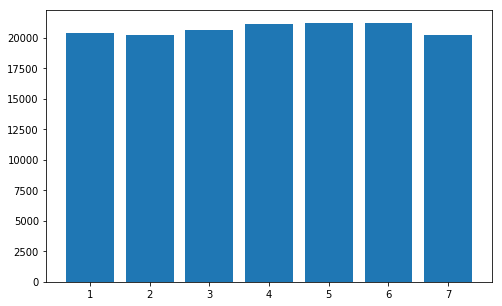

In [15]:
plt.figure(figsize=(8,5))

x, y = np.unique(df['weekday'], return_counts=True)
plt.bar(x, y)
plt.show()

In [16]:
df.groupby([df['TFS Alarm Time'].hour]).value_col.sum()

AttributeError: 'Series' object has no attribute 'hour'

In [278]:
times = pd.to_datetime(df['TFS Alarm Time'])
times

719036   2016-12-31 00:00:47
719037   2016-12-31 00:02:58
719038   2016-12-31 00:03:03
719039   2016-12-31 00:03:32
719040   2016-12-31 00:20:21
719041   2016-12-31 00:25:03
719042   2016-12-31 00:29:31
719043   2016-12-31 00:36:52
719044   2016-12-31 00:37:53
719045   2016-12-31 00:38:56
719046   2016-12-31 00:44:14
719047   2016-12-31 00:47:37
719048   2016-12-31 00:53:37
719049   2016-12-31 00:57:16
719050   2016-12-31 01:01:32
719051   2016-12-31 01:03:21
719052   2016-12-31 01:04:07
719053   2016-12-31 01:06:50
719054   2016-12-31 01:14:06
719055   2016-12-31 01:18:29
719056   2016-12-31 01:22:59
719057   2016-12-31 01:30:12
719058   2016-12-31 01:30:39
719059   2016-12-31 01:31:54
719060   2016-12-31 01:35:01
719061   2016-12-31 01:52:54
719062   2016-12-31 02:02:18
719063   2016-12-31 02:04:37
719064   2016-12-31 02:23:25
719065   2016-12-31 02:26:51
                 ...        
841429   2017-12-31 23:15:19
841430   2017-12-31 23:14:33
841431   2017-12-31 23:15:48
841432   2017-

In [284]:
df.dtypes

Incident Number                         object
Initial CAD Event Type                  object
Initial CAD Event Call Type             object
Final Incident Type                     object
Event Alarm Level                        int64
Call Source                             object
Incident Station Area                  float64
Incident Ward                            int64
LATITUDE                               float64
Longitude                              float64
Intersection                            object
TFS Alarm Time                  datetime64[ns]
TFS Arrival Time                datetime64[ns]
Last TFS Unit Clear Time        datetime64[ns]
Persons Rescued                        float64
TFS response time              timedelta64[ns]
weekday                                  int64
dtype: object